In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root_path = '/content/drive/MyDrive/Kvasir'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import * 
from keras.preprocessing import image
import os
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [5]:
#Defining paths
TRAIN_PATH = "/content/drive/MyDrive/Kvasir/Train"
TEST_PATH = "/content/drive/MyDrive/Kvasir/Test"

In [6]:
BATCH_SIZE = 64

# 70:20:10 = Training data:Validation data:Testing data

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.222,
                                     preprocessing_function=preprocess_input)

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

In [7]:
traingen = train_generator.flow_from_directory(TRAIN_PATH,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(TRAIN_PATH,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(TEST_PATH,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 5608 images belonging to 8 classes.
Found 1592 images belonging to 8 classes.
Found 800 images belonging to 8 classes.


In [8]:
from keras.metrics import top_k_categorical_accuracy
def top_5_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

In [9]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    pre_trained_model = InceptionV3(input_shape = input_shape, 
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')
    
    if fine_tune > 0:
      for layer in pre_trained_model.layers[:-fine_tune]:
        layer.trainable = False
    else:
      for layer in pre_trained_model.layers:
        layer.trainable = False


    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = pre_trained_model.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=pre_trained_model.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy', top_5_categorical_accuracy])
    
    return model

In [10]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.0001)
n_classes=8

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 30

# First we'll train the model without Fine-tuning
inception_model = create_model(input_shape, n_classes, optim_1, fine_tune=2)

87924736/87910968 [==============================] - 1s 0us/step


In [11]:
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [12]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [13]:
inception_history = inception_model.fit(traingen,
                                  batch_size=BATCH_SIZE,     
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,    
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop],
                                  verbose=1)

Epoch 1/30
87/87 [==============================] - ETA: 0s - loss: 1.9439 - accuracy: 0.4848 - top_5_categorical_accuracy: 0.9325 
Epoch 1: val_loss improved from inf to 0.94587, saving model to tl_model_v1.weights.best.hdf5
87/87 [==============================] - 2120s 24s/step - loss: 1.9439 - accuracy: 0.4848 - top_5_categorical_accuracy: 0.9325 - val_loss: 0.9459 - val_accuracy: 0.6335 - val_top_5_categorical_accuracy: 0.9889
Epoch 2/30
87/87 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.6097 - top_5_categorical_accuracy: 0.9895
Epoch 2: val_loss improved from 0.94587 to 0.89833, saving model to tl_model_v1.weights.best.hdf5
87/87 [==============================] - 1082s 12s/step - loss: 0.9770 - accuracy: 0.6097 - top_5_categorical_accuracy: 0.9895 - val_loss: 0.8983 - val_accuracy: 0.6315 - val_top_5_categorical_accuracy: 0.9909
Epoch 3/30
87/87 [==============================] - ETA: 0s - loss: 0.9212 - accuracy: 0.6315 - top_5_categorical_accuracy: 0

In [14]:
# Generate predictions
inception_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

inception_preds = inception_model.predict(testgen)
inception_pred_classes = np.argmax(inception_preds, axis=1)

In [15]:
true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

In [16]:
from sklearn.metrics import accuracy_score
inception_acc = accuracy_score(true_classes, inception_pred_classes)
print("InceptionV3 Model Accuracy: {:.2f}%".format(inception_acc * 100))

InceptionV3 Model Accuracy: 83.88%


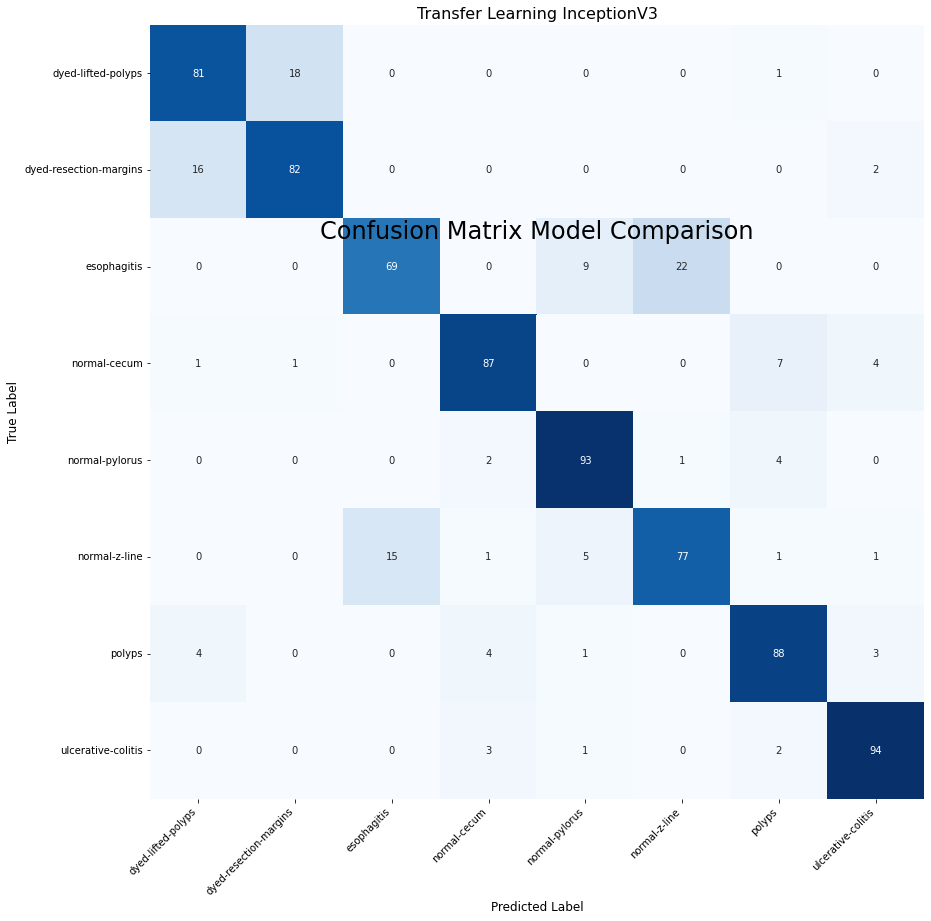

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the names of the ten classes
class_names = testgen.class_indices.keys()

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1,figsize=(20, 10))
    
plot_heatmap(true_classes, inception_pred_classes, class_names, ax1, title="Transfer Learning InceptionV3")    

fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()